In [1]:
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2019
tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = tournament_df[tournament_df["Season"] == YEAR]
tournament_df

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,SOS,Competition,Wins
0,2019,1101,Abilene Chr,Y15,15,-0.021108,-0.375821,-2.004979,-0.677338,-1.942276,-0.894141,0.0
42,2019,1113,Arizona St,X11a,11,0.540309,-0.020030,3.597716,2.568070,1.451221,0.934887,0.0
54,2019,1120,Auburn,Y05,5,0.668713,-0.330004,0.850967,3.250229,1.964265,1.364965,4.0
65,2019,1124,Baylor,X09,9,0.171236,-0.367754,-0.346217,1.919531,1.525257,1.131600,1.0
73,2019,1125,Belmont,W11a,11,1.075292,-0.026807,0.901575,3.871800,-0.347517,-0.150465,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2019,1439,Virginia Tech,W04,4,0.306598,-0.752115,-3.730767,3.649246,1.604288,1.110126,2.0
1055,2019,1449,Washington,Y09,9,-0.083146,-0.713522,-1.629446,1.834973,1.394724,0.859612,1.0
1107,2019,1458,Wisconsin,Z05,5,-0.115887,-0.929001,-4.360194,3.614545,2.304010,1.560116,0.0
1112,2019,1459,Wofford,Y07,7,0.598993,-0.527340,-2.922797,2.342440,-0.091967,0.097317,1.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2247,2019,W11,W11a,W11b
2248,2019,W16,W16a,W16b
2249,2019,X11,X11a,X11b
2250,2019,X16,X16a,X16b
2184,2019,R1W1,W01,W16
...,...,...,...,...
2242,2019,R4Y1,R3Y1,R3Y2
2243,2019,R4Z1,R3Z1,R3Z2
2244,2019,R5WX,R4W1,R4X1
2245,2019,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OwnScore_Zscore_B,OppScore_Zscore_A,OppScore_Zscore_B,Offense_A,Offense_B,Dominance_A,Dominance_B,SOS_A,SOS_B,Competition_A,Competition_B,Win_A
0,2003,1104,1328,0.144799,0.207507,-0.335313,-0.863963,-0.755118,-3.573729,3.420866,3.564440,1.808134,2.096693,1.378513,1.181115,True
1,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.573729,2.197156,3.564440,4.765952,2.096693,2.262017,1.181115,1.321327,False
2,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.573729,2.197156,3.564440,4.765952,2.096693,2.262017,1.181115,1.321327,False
3,2003,1281,1328,0.297116,0.207507,-0.342031,-0.863963,-0.563626,-3.573729,3.422770,3.564440,2.253370,2.096693,1.340966,1.181115,True
4,2003,1328,1329,0.207507,-0.064060,-0.863963,-0.740947,-3.573729,-1.235750,3.564440,2.115383,2.096693,1.873838,1.181115,1.223438,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4952,2019,1209,1243,0.283263,-0.404416,0.032907,-1.112603,1.561783,-5.395697,1.030749,2.069185,0.129268,1.852485,0.113073,1.377838,False
4953,2019,1209,1285,0.283263,0.099479,0.032907,-0.340951,1.561783,-2.116064,1.030749,-0.055944,0.129268,-0.800677,0.113073,-0.561377,False
4954,2019,1209,1251,0.283263,-0.223065,0.032907,-0.890404,1.561783,-6.511350,1.030749,0.485783,0.129268,-0.427815,0.113073,-0.157060,False
4955,2019,1124,1341,0.171236,0.336226,-0.367754,0.325131,-0.346217,2.933735,1.919531,-1.405578,1.525257,-1.674359,1.131600,-0.969110,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",
    "Offense_A", "Offense_B",
    "Dominance_A", "Dominance_B",
    "SOS_A", "SOS_B",
    "Competition_A", "Competition_B"
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.6572523703853137,
 array([[ 0.33550312, -0.38278248, -0.40732479,  0.33624573, -0.00098818,
          0.10131534,  0.1715379 , -0.15993258,  0.05296985, -0.00327401,
          0.52275839, -0.52320096]]))

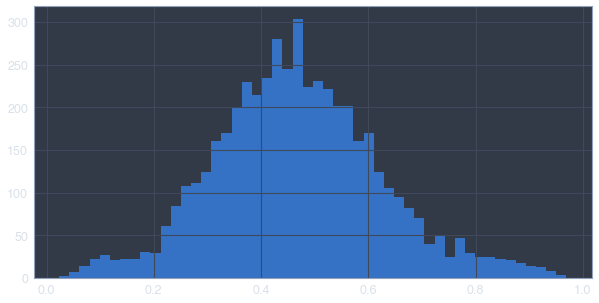

In [7]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [8]:
SIMULATION_ROUNDS = 1000
total_stats = defaultdict(lambda: defaultdict(int))
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for i, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = [[
            team_a["OwnScore_Zscore"],
            team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"],
            team_b["OppScore_Zscore"],
            team_a["Offense"],
            team_b["Offense"],
            team_a["Dominance"],
            team_b["Dominance"],
            team_a["SOS"],
            team_b["SOS"],
            team_a["Competition"],
            team_b["Competition"],
        ]]
        prob = reg.predict_proba(scaler.transform(predict_data))[0][0]
        winning_team = team_a if random.random() > prob else team_b
        slots_dict[r["Slot"]] = winning_team
        total_stats[winning_team["TeamID"]]["wins"] += 1        
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1

100%|██████████| 1000/1000 [00:12<00:00, 77.66it/s]


In [9]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed", "Offense", "Dominance", "SOS", "Competition",
    "Wins", "MeanWins", "PercentChampion"
]]

In [10]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    for line in range(len(x)):
         p1.text(
             x[line]+0.02, y[line], 
             labelseries[line], size=labelsize, color=labelcolor
         )
    return p1

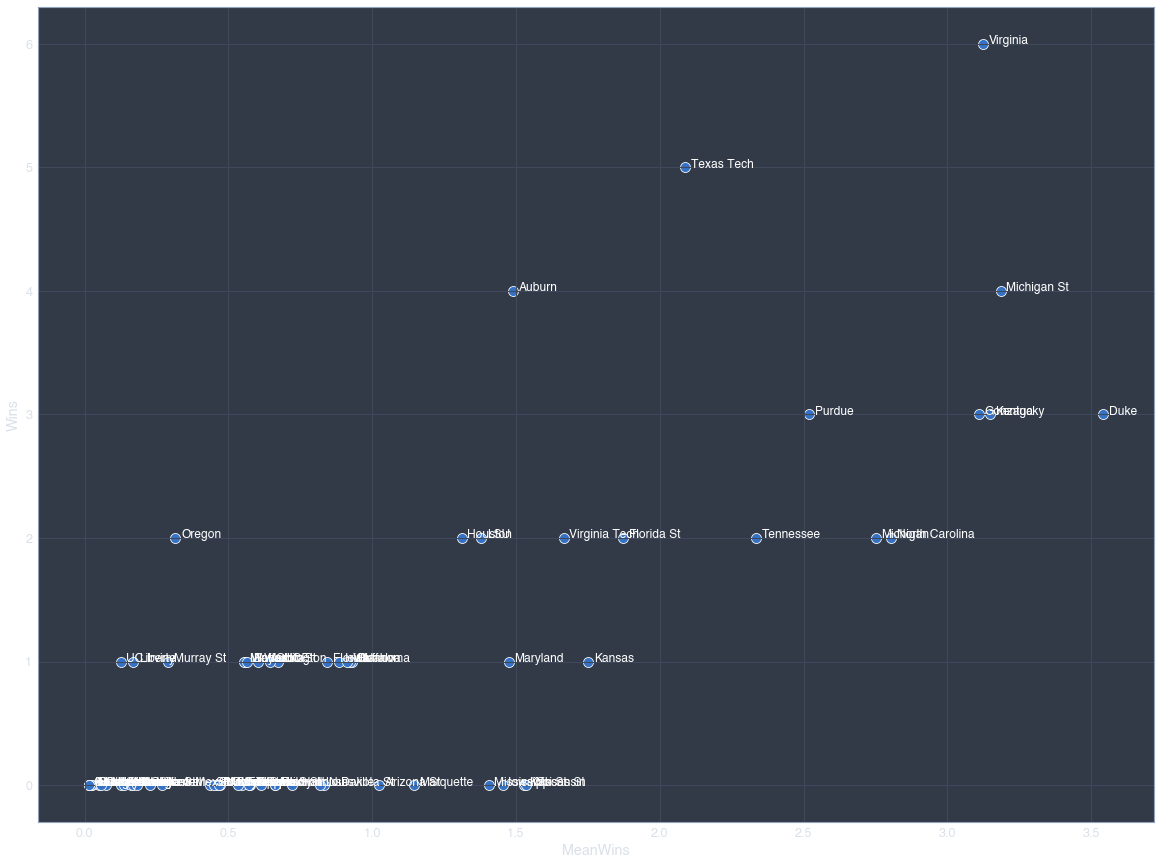

In [11]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["MeanWins"], y=simulation_df["Wins"], s=100,
    labelseries=simulation_df["TeamName"], labelcolor="white"
);

In [12]:
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[:10]

,TeamID,TeamName,Seed,Offense,Dominance,SOS,Competition,Wins,MeanWins,PercentChampion
4,1181,Duke,W01,2.814487,6.899208,2.477871,1.516361,3.0,3.541,0.182
5,1277,Michigan St,W02,0.747121,6.562812,2.437117,1.825314,4.0,3.185,0.157
28,1438,Virginia,Z01,-6.850576,5.055268,1.927567,1.299530,6.0,3.125,0.130
12,1211,Gonzaga,X01,0.996736,7.722752,0.860812,0.750569,3.0,3.110,0.104
21,1246,Kentucky,Y02,-2.204987,5.667129,2.110250,1.480834,3.0,3.147,0.089
20,1314,North Carolina,Y01,4.495421,5.949526,2.570344,1.453276,2.0,2.805,0.072
13,1276,Michigan,X02,-5.596630,4.663410,2.214741,1.624375,2.0,2.751,0.064
30,1345,Purdue,Z03,-0.262152,4.525195,2.468306,1.676658,3.0,2.518,0.052
29,1397,Tennessee,Z02,0.220444,5.240624,1.996177,1.528070,2.0,2.335,0.036
14,1403,Texas Tech,X03,-3.105922,3.400909,1.462553,1.163996,5.0,2.087,0.019


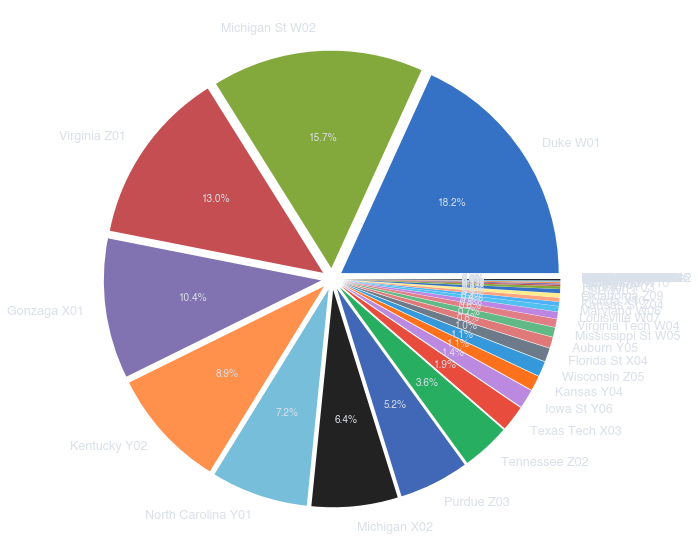

In [13]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);